In [371]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from scipy.optimize import LinearConstraint

# Single round

In [309]:
p = 10
n = 1000
M = 1+p+int(p*(p-1)/2)
sigma = 1
l = -1
h = 1
K = max(np.abs(l),np.abs(h))**2*p
half = np.array([.5]*p)

In [310]:
def makeX(d):
    p = len(d)
    X = []
    for _ in range(n):
        S = [2*np.random.binomial(1, d[i])-1 for i in range(p)]
        x = [1]
        x.extend(S)
        for i in range(p):
            for j in range(i+1, p):
                x.append(S[i]*S[j])
        X.append(x)
    return X

In [311]:
beta = np.random.uniform(low = l, high = h, size = M)
print(beta)

[ 0.42248741  0.67528428  0.63070605 -0.35118133 -0.936229   -0.3818946
  0.23884724 -0.07972491  0.67310511 -0.89355464 -0.13836841 -0.9737349
 -0.42340795 -0.46313462  0.45543789  0.12029968 -0.62275811  0.81216616
 -0.34361723  0.24430462 -0.17621218  0.25260276  0.50123738  0.61236897
 -0.64991809 -0.57826931  0.7750935  -0.72907101  0.35326899  0.32268384
  0.24457546 -0.47306162  0.85968463 -0.68180447 -0.16129819  0.10265345
  0.81589416  0.15956352  0.82930929 -0.1179666   0.73405225 -0.65361365
  0.33545819  0.30109038 -0.51400126 -0.34434806 -0.4246017  -0.72621568
  0.27285162  0.21826284  0.8959912  -0.15305148  0.57721759 -0.4256002
  0.32633659  0.45834767]


In [344]:
def single_round(beta, d):
    X = makeX(d)
    y = np.matmul(X, np.reshape(beta,(M,1)))+np.random.normal(loc = 0, scale = sigma, size = (n,1))
    XTX = np.matmul(np.transpose(X), X)

    #while True:
    evals = np.real_if_close(np.linalg.eigvals(XTX), tol=100)
    min_ev = min(evals)
    if not np.isreal(min_ev):
        min_ev=0
        ols_bound = float('inf')
        ridge_bound = K
    else:
        ols_bound = M*sigma**2/min_ev
        ridge_bound = K*M*n*sigma**2/(K*min_ev**2+M*n*sigma**2)
    
    if ols_bound<ridge_bound:
        m = "ols"
        reg = LinearRegression(fit_intercept = False).fit(X, y)
        beta_hat = reg.coef_
        #print(ols_bound)
    else:
        m = "ridge"
        if min_ev == 0 or not np.isreal(min_ev):
            beta_hat = [0]*M
        else:
            lambda_ridge = sigma**2*M*n/(K*min_ev)
            clf = Ridge(alpha=lambda_ridge, fit_intercept = False)
            clf.fit(X, y)
            beta_hat = clf.coef_
        #print(ridge_bound)
    return np.linalg.norm(beta-beta_hat)**2
def truncate(x):
    if 0<x<1:
        return x
    elif x>1:
        return 1
    return 0

In [326]:
dist = []
results = []
trials = 100
for t in range(trials):
    d = np.random.normal(loc = .5, scale = .2, size = p)
    d = [truncate(d[i]) for i in range(p)]
    #if t<1:
    #    d = half
    r = single_round(beta, d)
    if r<100:
        dist.append(max([np.abs(2*d[i]-1) for i in range(p)]))
        #dist.append(np.linalg.norm(d-half))
        results.append(r)

KeyboardInterrupt: 

### Single beta, 100 random dosages

(0.0, 1.0)

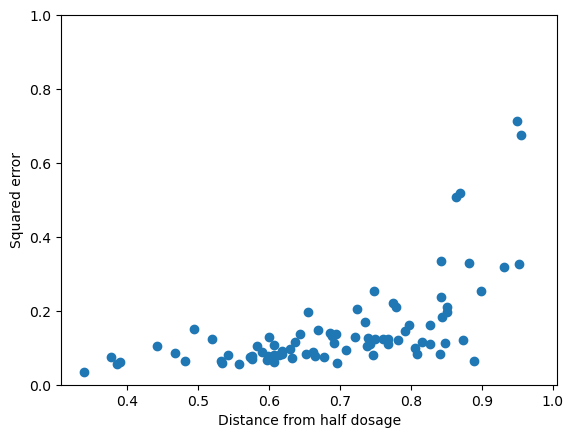

In [322]:
plt.scatter(dist, results)
plt.xlabel("Distance from half dosage")
plt.ylabel("Squared error")
plt.ylim(0,1)

In [352]:
xs = np.arange(.2, .81, .02)
results = []
trials = 100
for x in xs:
    d = [x]*p
    s = 0
    for t in range(trials):
        s += single_round(beta, d)
    results.append(s/trials)

### Single beta, 100 trials per dosage

Text(0, 0.5, 'Average squared error')

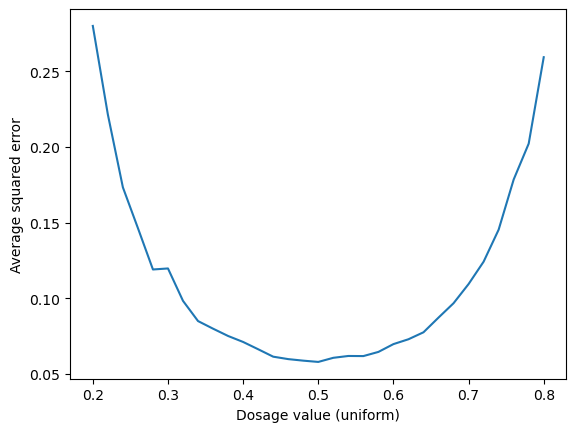

In [353]:
plt.plot(xs, results)
plt.xlabel("Dosage value (uniform)")
plt.ylabel("Average squared error")
#plt.ylim(0,1)

# Multiple rounds

In [450]:
#1/2 every round vs optimized Sigma each round
n = 1000
num_rounds = 10

def common(a,b):
    return len(set(a)&set(b))

def makeSigma(d):
    p = len(d)
    s = [set([])]
    s.extend([set([i]) for i in range(p)])
    for i in range(p):
        for j in range(i+1, p):
            s.append(set([i,j]))
    M = int(1+p+p*(p-1)/2)
    A = np.zeros((M,M))
    for i in range(M):
        for j in range(M):
            A[i][j] = 1
            for l in s[i].symmetric_difference(s[j]):
                A[i][j] *= (2*d[l]-1)
    return A

def new_d(P):
    def f(d):
        evals = np.real_if_close(np.linalg.eigvals(makeSigma(d)+P))
        if not np.isreal(min(evals)):
            return 0
        return -min(evals)
    linear_constraint = LinearConstraint([[1]*p], [0], [1])
    res = sp.optimize.minimize(f, x0 = half, method = 'SLSQP', bounds = [(0,1)]*p)
    return res.x

In [457]:
beta = np.random.uniform(low = l, high = h, size = M)
d0 = [.5]*p

X = makeX(d0)

error = []
error.append(multiple_round(beta, X))

XTX = np.matmul(np.transpose(X), X)
min_evals = [min(np.real_if_close(np.linalg.eigvals(XTX)))]

for r in range(num_rounds):
    P = 1/n*np.matmul(np.transpose(X), X)
    d = new_d(P)
    d = list(d)
    print([round(y,2) for y in d])
    X.extend(makeX(d))
    XTX = np.matmul(np.transpose(X), X)
    min_evals.append(min(np.real_if_close(np.linalg.eigvals(XTX))))
    error.append(multiple_round(beta, X))

[0.52, 0.5, 0.51, 0.49, 0.49, 0.5, 0.51, 0.5, 0.49, 0.48]
[0.51, 0.51, 0.52, 0.48, 0.51, 0.49, 0.48, 0.5, 0.5, 0.43]
[0.52, 0.48, 0.51, 0.48, 0.47, 0.5, 0.52, 0.49, 0.5, 0.46]
[0.5, 0.47, 0.5, 0.48, 0.44, 0.54, 0.52, 0.51, 0.47, 0.48]
[0.49, 0.52, 0.51, 0.5, 0.51, 0.46, 0.43, 0.5, 0.49, 0.5]
[0.52, 0.53, 0.48, 0.52, 0.55, 0.44, 0.44, 0.48, 0.42, 0.48]
[0.51, 0.51, 0.44, 0.54, 0.51, 0.5, 0.48, 0.5, 0.51, 0.49]
[0.51, 0.52, 0.53, 0.48, 0.56, 0.58, 0.54, 0.53, 0.48, 0.55]
[0.52, 0.47, 0.49, 0.47, 0.47, 0.53, 0.55, 0.52, 0.49, 0.51]
[0.5, 0.46, 0.49, 0.48, 0.52, 0.47, 0.52, 0.56, 0.5, 0.61]


In [458]:
X = makeX(d0)

error_half = []
error_half.append(multiple_round(beta, X))

XTX = np.matmul(np.transpose(X), X)
min_evals_half = [min(np.real_if_close(np.linalg.eigvals(XTX)))]

for r in range(num_rounds):
    X.extend(makeX(half))
    XTX = np.matmul(np.transpose(X), X)
    min_evals_half.append(min(np.real_if_close(np.linalg.eigvals(XTX))))
    error_half.append(multiple_round(beta, X))

### Single beta

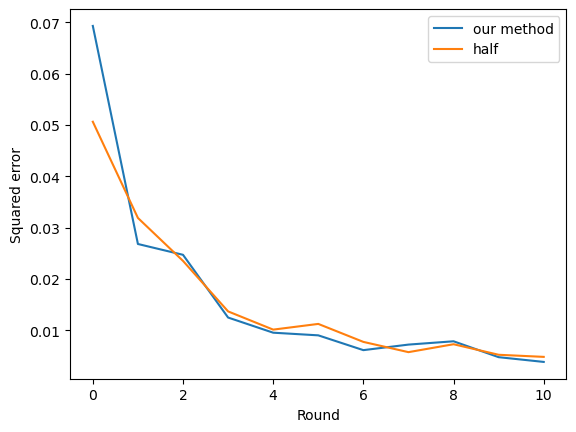

In [459]:
plt.plot(range(num_rounds+1), error, label="our method")
plt.plot(range(num_rounds+1), error_half, label = "half")
plt.xlabel("Round")
plt.ylabel("Squared error")
plt.legend()

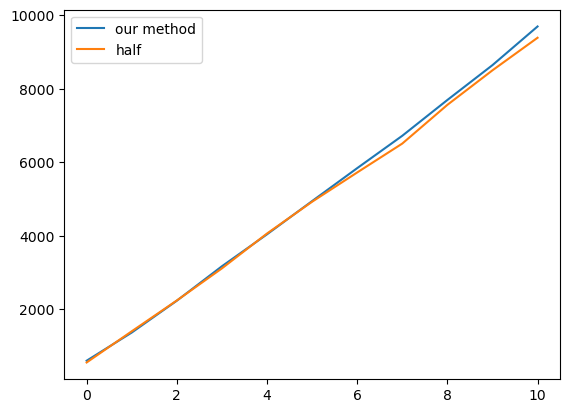

In [430]:
plt.plot(range(num_rounds+1), min_evals, label="our method")
plt.plot(range(num_rounds+1), min_evals_half, label = "half")
plt.legend()

In [401]:
def multiple_round(beta, X):
    y = np.matmul(X, np.reshape(beta,(M,1)))+np.random.normal(loc = 0, scale = sigma, size = (len(X),1))
    XTX = np.matmul(np.transpose(X), X)

    evals = np.real_if_close(np.linalg.eigvals(XTX), tol=100)
    min_ev = min(evals)
    if not np.isreal(min_ev):
        min_ev=0
        ols_bound = float('inf')
        ridge_bound = K
    else:
        ols_bound = M*sigma**2/min_ev
        ridge_bound = K*M*n*sigma**2/(K*min_ev**2+M*n*sigma**2)
    
    if ols_bound<ridge_bound:
        m = "ols"
        reg = LinearRegression(fit_intercept = False).fit(X, y)
        beta_hat = reg.coef_
    else:
        m = "ridge"
        if min_ev == 0 or not np.isreal(min_ev):
            beta_hat = [0]*M
        else:
            lambda_ridge = sigma**2*M*n/(K*min_ev)
            clf = Ridge(alpha=lambda_ridge, fit_intercept = False)
            clf.fit(X, y)
            beta_hat = clf.coef_
    return np.linalg.norm(beta-beta_hat)**2